# Note
This notebook is to train the encoder as a classifier with the idea of validate the encoder architecture first and then use this to train the VAE.

# Parameters to experiment

In [47]:
# training on guanaco
# ATENTION: if it is going to run on guanaco:
# 1) comment the %matplotlib magic in next block and any magic (something like %code)
# 2) Change to True the trainingOnGuanaco vairbale
# 3) set epoch with an appropiate number
# 4) add comment to experiemnts
# 5) Add this file as python file 
# 6) Change launchJobOnGuanaco file to run this file but with python format
trainingOnGuanaco = False

# train without notebook
trainWithJustPython = False

# number_experiment (this is just a name)
# priors:
# 1
number_experiment = 12
number_experiment = str(number_experiment)

# seed to generate same datasets
seed = 1

# training
epochs = 10000

# max elements by class
max_elements_per_class = 15000

# train with previous model
trainWithPreviousModel = True

# include delta errors
includeDeltaErrors = False

# band
# passband = [5]
passband = [0, 1, 2, 3, 4, 5]

In [48]:
# cuda device
cuda_device = 0
cuda_device = "cuda:" + str(cuda_device)

# classes to analyze
# 42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#        95,   6,  53, 994,  64

# periodic
# only_these_labels = [16, 92, 53]

# periodic + variable
only_these_labels = [16, 92, 53, 88, 65, 6]
# 53 has 24 light curves

# only_these_labels = [16, 92]
# only_these_labels = [16, 92]
# only_these_labels = [42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#         95,   6,  53, 994,  64]

# VAE parameters
latentDim = 100
hiddenDim = 100
inputDim = 72

batch_training_size = 128

# early stopping 
threshold_early_stop = 1000

In [49]:
# training params
learning_rate = 1e-3

In [50]:
# add general comment about experiment 
# comment = "encoder as clasifier with periodic + variable (with class balancing) + 1 conv layer more"
comment = "exp " + number_experiment + " + encoder as clasifier with periodic + variable + class balancing + 1 conv layer more + " + str(len(passband)) + " channels + seed " + str(seed) + " + " + ("include delta errors" if includeDeltaErrors else "without delta errors") + " + max by class " + str(max_elements_per_class)

print(comment)

exp 12 + encoder as clasifier with periodic + variable + class balancing + 1 conv layer more + 6 channels + seed 1 + without delta errors + max by class 15000


# Import libraries

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils import data

# from tqdm import tqdm_notebook

# %matplotlib notebook

# import functions to load dataset
import sys
sys.path.append("./codesToDatasets")
from plasticc_dataset_torch import get_plasticc_datasets
# from plasticc_plotting import plot_light_curve

import math

from torch import nn

# local imports
# %load_ext autoreload
# %autoreload 2
sys.path.append('../models')
# from classifier import EncoderClassifier, 
from classifierPrototype import EncoderClassifier

sys.path.append("./aux/")
from auxFunctions import *

from sklearn.model_selection import train_test_split

## Load the path to save model while training

In [52]:
import os

# create experiment's folder
tmpGuanaco = "/home/lbravo/thesis/thesis/work/thesis/"
tmpLocal = "/home/leo/Desktop/thesis/work/thesis/"

expPath = "experiments/" + number_experiment + "/seed" + str(seed) + "/maxClass" + str(int(max_elements_per_class/1000)) + "k"

folder_path = (tmpGuanaco + expPath) if trainingOnGuanaco else (tmpLocal + expPath)
# !mkdir folder_path
# os.makedirs(os.path.dirname(folder_path), exist_ok=True)

# check if folder exists
if not(os.path.isdir(folder_path)):
        
    # create folder
    try:
        os.makedirs(folder_path)
        
    except OSError as error:
        print ("Creation of the directory %s failed" % folder_path)
        print(error)
    else:
        print ("Successfully created the directory %s " % folder_path)
else:
    print("folder already exists")

# define paht to save model while training
pathToSaveModel = (tmpGuanaco + expPath + "/model") if trainingOnGuanaco else (tmpLocal + expPath + "/model")

folder already exists


# Load data

In [7]:
# define path to dataset
pathToFile = "/home/shared/astro/PLAsTiCC/" if trainingOnGuanaco else "/home/leo/Downloads/plasticData/"

## Loading dataset with pytorch tool

In [8]:
# torch_dataset_lazy = get_plasticc_datasets(pathToFile)

# Light curves are tensors are now [bands, [mjd, flux, err, mask],
# lc_data, lc_label, lc_plasticc_id                              
torch_dataset_lazy = get_plasticc_datasets(pathToFile, only_these_labels=only_these_labels, max_elements_per_class = max_elements_per_class)

You have selected lazy loading. Light curves will be loaded ondemand from the harddrive
Found 2 csv files at given path
Loading /home/leo/Downloads/plasticData/plasticc_train_lightcurves.csv
Loading /home/leo/Downloads/plasticData/plasticc_test_set_batch1.csv


In [9]:
assert torch_dataset_lazy.__len__() != 494096, "dataset should be smaller"
print("dataset test ok")

dataset test ok


# Spliting data (train/test)

In [10]:
# splitting the data

# get light curves ids, targets
ids, targets, lightCurvesIds = getLightCurvesIds(torch_dataset_lazy)

# test array shapes
# assert len(targets) == torch_dataset_lazy.__len__()
# print(ids, len(ids), targets, len(targets))
# get light curves targets
print("# light curves ids: " + str(len(ids)))

# split training
trainIdx, tmpIdx = train_test_split(
    ids,
    test_size = 0.2,
    shuffle = True,
    stratify = targets,
    random_state = seed
)

# float to int
tmpIdx = tmpIdx.astype(int)

# split val, test
valIdx, testIdx = train_test_split(
    tmpIdx,
#     targets,
    test_size = 0.5,
    shuffle = True,
    stratify = targets[tmpIdx],
    random_state = seed
)

# float to int
trainIdx = trainIdx.astype(int)
valIdx = valIdx.astype(int)
testIdx = testIdx.astype(int)

# light curves ids: 3276


(array([ 16.,  93.,   0.,   0.,   0.,   4., 104.,   0.,   0., 111.]),
 array([ 6. , 14.6, 23.2, 31.8, 40.4, 49. , 57.6, 66.2, 74.8, 83.4, 92. ]),
 <BarContainer object of 10 artists>)

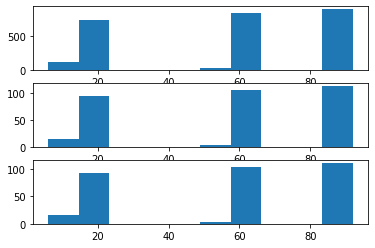

In [11]:
# # analize classes distributino
fig, ax = plt.subplots(3, 1)

ax[0].hist(targets[trainIdx])
ax[1].hist(targets[valIdx])
ax[2].hist(targets[testIdx])

In [12]:
# # Spliting the data

# # print(torch_dataset_lazy.__len__())

totalSize = torch_dataset_lazy.__len__()

# totalSize = totalSize
# # print(totalSize)

# selecting train splitting
# train_size = int(0.8 * totalSize)
train_size = trainIdx.shape[0]
#print(train_size)

# # getting test splitting
# validation_size = math.floor((totalSize - train_size)/3)
validation_size = valIdx.shape[0]
# #print(validation_size)

# # getting test splitting
# test_size = totalSize - train_size - validation_size
test_size = testIdx.shape[0]
# #print(test_size)

# # spliting the torch dataset
# trainDataset, validationDataset,  testDataset = torch.utils.data.random_split(
#     torch_dataset_lazy, 
#     [train_size, validation_size, test_size],
    
#     # set seed
#     generator = torch.Generator().manual_seed(seed)
# )

print("train size:", train_size)
print("validation size: ", validation_size)
print("test size:", test_size)
totTmp = train_size+ validation_size + test_size
print("sum: ", totTmp)
assert torch_dataset_lazy.__len__() == totTmp, "dataset partition should be the same"

train size: 2620
validation size:  328
test size: 328
sum:  3276


## Create a dataloader

In [13]:
# # Create data loader (minibatches)

# training loader
trainLoader = torch.utils.data.DataLoader(
    torch_dataset_lazy, 
    batch_size = batch_training_size, 
    # to balance classes
    sampler=ImbalancedDatasetSampler(
        torch_dataset_lazy, 
        indices = trainIdx,
        seed = seed
#         indices = [0, 1, 2]
    ),
    # each worker retrieve data from disk, so the data will be ready to be processed by main process. The main process should get the data from disk, so if workers > 0, the workers will get the data (not the main process)
    num_workers = 4,
    
    # https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/
    # the dataloader loads the data in pinned memory (instead of pageable memory), avoiding one process (to transfer data from pageable memory to pinned memory, work done by CUDA driver)
    pin_memory = True,
)


# validation loader
validationLoader = torch.utils.data.DataLoader(
#     validationDataset, 
    torch_dataset_lazy,
    batch_size= batch_training_size,  
    num_workers = 4,
    pin_memory = True,
    sampler = torch.utils.data.SubsetRandomSampler(
        valIdx,
        generator = torch.Generator().manual_seed(seed)
    ),
)

# # test loader
# testLoader = torch.utils.data.DataLoader(testDataset)
testLoader = torch.utils.data.DataLoader(
#     validationDataset, 
    torch_dataset_lazy,
#     batch_size= batch_training_size,  
    num_workers = 4,
    pin_memory = True,
    sampler = torch.utils.data.SubsetRandomSampler(
        testIdx,
        generator = torch.Generator().manual_seed(seed)
    ),
)

## Defining parameters to Autoencoder

In [14]:
# check number of parameters
# latentDim = 5
# hiddenDim = 10
# inputDim = 72

latentDim = latentDim
hiddenDim = hiddenDim
inputDim = inputDim

# passband = passband

num_classes = len(only_these_labels)

if trainWithPreviousModel:
    
    # loadgin model
    model = torch.load(pathToSaveModel + ".txt").to(device = cuda_device)
    
    print("loading saved model")
    
else:
    
    # defining model
    model = EncoderClassifier(latent_dim = latentDim, hidden_dim = hiddenDim, input_dim = inputDim, num_classes = num_classes, passband = passband, includeDeltaErrors = includeDeltaErrors)

    # mdel to GPU
    model = model.to(device = cuda_device)
    
    print("creating model with default parameters")

loading saved model


In [15]:
print(model)

EncoderClassifier(
  (pconv1): PartialConv(
    (input_conv): Conv1d(6, 64, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(6, 64, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv2): PartialConv(
    (input_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv3): PartialConv(
    (input_conv): Conv1d(32, 32, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(32, 32, kernel_size=(3,), stride=(2,), bias=False)
  )
  (hidden1): Linear(in_features=512, out_features=100, bias=True)
  (outputLayer): Linear(in_features=100, out_features=6, bias=True)
  (activationConv): ReLU()
  (activationLinear): ReLU()
)


In [16]:
# get metrics on trainig dataset
getConfusionAndClassificationReport(trainLoader, nameLabel = "Train", passband = passband, model = model, staticLabels = only_these_labels, number_experiment = number_experiment, expPath = expPath, includeDeltaErrors = includeDeltaErrors)


# get metrics on validation dataset
getConfusionAndClassificationReport(validationLoader, nameLabel = "Validation", passband = passband, model = model, staticLabels = only_these_labels, number_experiment = number_experiment, expPath = expPath, includeDeltaErrors = includeDeltaErrors)

saving confusion matrix scores with normalize: true
saving confusion matrix scores with normalize: pred
saving confusion matrix scores with normalize: all
saving clasification report


/home/leo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


saving confusion matrix scores with normalize: true
saving confusion matrix scores with normalize: pred
saving confusion matrix scores with normalize: all
saving clasification report


### Stop execution if it's on cluster

In [17]:
import sys

if  trainingOnGuanaco or trainWithJustPython:

    sys.exit("Exit from code, because we are in cluster or running locally. Training has finished.")

SystemExit: Exit from code, because we are in cluster or running locally. Training has finished.

/home/leo/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Analyzing training

In [45]:
!cat ../experiments/11/seed1/maxClass15k/experimentParameters.txt

N° experiment: 11
 General comment: exp 11 + encoder as clasifier with periodic + variable + class balancing + 1 conv layer more + 1 channels + seed 1 + without delta errors + max by class 15000
 Classes: [16, 92, 53, 88, 65, 6]
 train_size: 52360
 validation_size: 6545
 test_size: 6546
 total dataset size: 65451
 Epochs: 10000
 Latent dimension: 100
 Hidden dimension: 100
 Input dimension: 72
 Passband: [5]
 Learning rate: 0.001
 Batch training size: 128
 initial train classes distribution: [ 1454 15924  1483 15981 15370 15239]
balanced train class distribution: [8536. 8712. 8742. 8755. 8789. 8826.]

experiments/12/seed1/maxClass15k


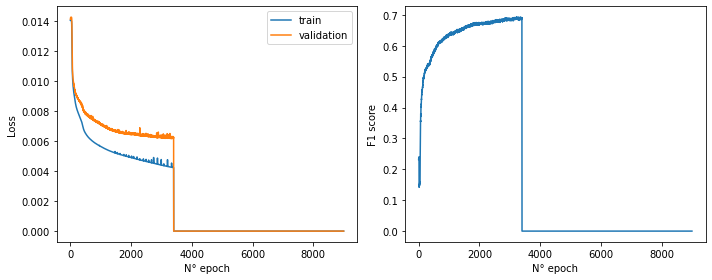

In [53]:
# load losses array
# losses = pd.read_csv("/home/leo/Desktop/thesis/work/thesis/experiments/"+ number_experiment + "/seed" + str(seed) + "/training_losses.csv")
losses = pd.read_csv(folder_path + "/training_losses.csv")
# f1 scores
# f1Scores = pd.read_csv("/home/leo/Desktop/thesis/work/thesis/experiments/" + number_experiment + "/seed" + str(seed) + "/maxClass15k" + "/f1Scores.csv")
f1Scores = pd.read_csv(folder_path + "/f1Scores.csv")

# plot losses
fig, ax = plt.subplots(1, 2, figsize = (10,4), tight_layout = True)

# loss
ax[0].set_xlabel("N° epoch")
ax[0].set_ylabel("Loss")
ax[0].plot(losses.iloc[:9000, 0], label = "train")
ax[0].plot(losses.iloc[:9000, 1], label = "validation")
ax[0].legend()

# f1 scores
ax[1].set_xlabel("N° epoch")
ax[1].set_ylabel("F1 score")
ax[1].plot(f1Scores[:9000])

print(expPath)
# best model
# values copied from the txt file
# bestModelEpoch = 785
# bestModelError = 0.00434128265165168
# ax[0].scatter(bestModelEpoch, bestModelError, c = "r", linewidths = 10)
# ax[1].scatter(bestModelEpoch, f1Scores.iloc[bestModelEpoch], c = "r", linewidths = 10)

In [54]:
!cat ../experiments/12/seed1/maxClass15k/bestScoresModelTraining.txt

Epoch: 3336
 Reconstruction test error: 0.006154959943114209

Training
Normalization: true


<AxesSubplot:>

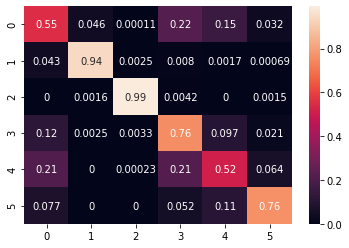

In [11]:
# confusion matrix
import pandas as pd
import seaborn as sn

# select normalization
# norm = {‘true’, ‘pred’, ‘all’}
normalization = "true"

# get confusion matrix
cmTrain = pd.read_csv(tmpLocal + expPath  + '/confusionMatrixTrain_norm_' + normalization + '.csv', header = None) 
cmValidation = pd.read_csv(tmpLocal + expPath + '/confusionMatrixValidation_norm_' + normalization + '.csv', header = None) 

print("Training")
print("Normalization: " + normalization)
sn.heatmap(cmTrain, annot=True)

Validation


<AxesSubplot:>

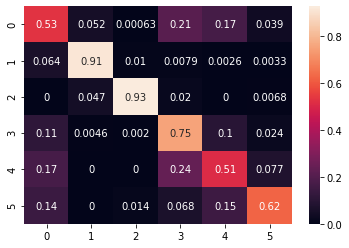

In [12]:
print("Validation")
sn.heatmap(cmValidation, annot = True)

In [13]:
# classification report
!cat ../experiments/12/seed0/maxClass15k/clasificationReportTrain.txt

              precision    recall  f1-score   support

         0.0       0.56      0.55      0.55      8776
         1.0       0.95      0.94      0.95      8703
         2.0       0.99      0.99      0.99      8609
         3.0       0.60      0.76      0.67      8751
         4.0       0.59      0.52      0.55      8730
         5.0       0.87      0.76      0.81      8791

    accuracy                           0.75     52360
   macro avg       0.76      0.75      0.75     52360
weighted avg       0.76      0.75      0.75     52360


In [14]:
# classification report
!cat ../experiments/12/seed0/maxClass15k/clasificationReportValidation.txt

              precision    recall  f1-score   support

         0.0       0.60      0.53      0.56      1592
         1.0       0.93      0.91      0.92      1524
         2.0       0.86      0.93      0.89       148
         3.0       0.61      0.75      0.67      1537
         4.0       0.65      0.51      0.57      1598
         5.0       0.29      0.62      0.39       146

    accuracy                           0.68      6545
   macro avg       0.66      0.71      0.67      6545
weighted avg       0.69      0.68      0.68      6545
